<a id="top"></a>
## Table of Contents
* [0. Project Description](#0)
* [1. Libraries](#1)
* [2. Data Collection](#2)
    - [2.1 Data Loader](#2.1)
    - [2.2 An Overview of the Data](#2.2)
* [3. Exploratory Data Analysis](#3) 
    - [3.1 Statistics](#3.1)
        - [3.1.1 Distribution of Labels](#3.1.1)
        - [3.1.2 Distribution of Document Lengths](#3.1.2)
        - [3.1.3 Overlab between query and title](#3.1.3)
    - [3.2 Summary of EDA and Futer steps](#3.2)
* [4. Data Module](#4)
    - [4.1 Pre-processing](#4.1)
        - [4.1.1 Flitering out the Outliers](#4.1.1)
        - [4.1.2 Upsampling of the training data via LLMs](#4.1.2)
    - [4.2 Overview of the New Dataset](#4.2)
* [5. Model Module](#5)
* [6. Results](#6)
* [7. Conclusion & Future Development](#7)

The source code and basic project setup are available at https://github.com/lijunfeng99/CS5242-project_25

##  0. <a name='0'></a>Project Description
[Back to Table of Contents](#top)

### Exploring Language Models for Query-Document Relevance Prediction on the QBQTC Dataset

In this project, we aim to explore the effectiveness of various deep learning-based language models in predicting query-document relevance using the QBQTC dataset. Specifically, we will experiment with three prominent architectures: Recurrent Neural Networks (RNN), Transformer models, and BERT (Bidirectional Encoder Representations from Transformers).

The QBQTC (QQ Browser Query Title Corpus) dataset is a large-scale Learning to Rank (LTR) dataset developed by the QQ Browser search engine team. It is designed for general web search scenarios and incorporates multi-dimensional annotations, including relevance, authority, content quality, and timeliness. For this project, we focus on the relevance labels, which indicate how well a given document title matches a user query:

- 0: Poor relevance
- 1: Moderately relevant
- 2: Highly relevant

The dataset is split into the following subsets:

Training set: 180,000 samples
Development set: 20,000 samples
Public test set: 5,000 samples
Our goal is to build and compare models that can effectively predict the relevance score between a query and a document title. The performance of each model will be evaluated on the development and test sets using appropriate ranking and classification metrics.

Through this project, we aim to understand the relative strengths and limitations of different neural language model architectures in the context of information retrieval and learning to rank tasks.

##  1. <a name='1'></a>Libraries
[Back to Table of Contents](#top)

In [1]:
%matplotlib inline
import os
import math
import json
import jieba
import collections
import random
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm


import matplotlib.pyplot as plt
import seaborn as sns

import torch
import ollama

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

##  2. <a name='2'></a>Data Collection
[Back to Table of Contents](#top)

For data collection, we first collected about 6000 reviews data for the first time. However, after data analysis, we found that the distribution and proportion of the data were seriously uneven.The main problem is that the negative and neutral data are seriously insufficient, and the second is that the data of some aspects is also seriously insufficient. So we scoured multiple websites, controlling the data tags for each crawl, and finally got our current dataset.

###  2.1 <a name='2.1'></a> Data Loader

To prepare the QBQTC dataset for model training and evaluation, we implemented a custom data loader in Python to handle the JSON-formatted data files. The dataset is stored in three separate files: `train.json`, `dev.json`, and `test.json`, located in the `./dataset/` directory.

We defined a function read_json_file to read each file line by line and parse each line as a JSON object. This approach ensures robustness against potential formatting issues, as it skips any lines that cannot be properly parsed.

In [2]:
dataset_path = './dataset/'

def read_json_file(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                item = json.loads(line.strip())
                data.append(item)
            except json.JSONDecodeError:
                print(f"Error parsing line: {line}")
    return data

files = ['train.json', 'dev.json', 'test.json']
data_dict = {}

for file in files:
    file_path = os.path.join(dataset_path, file)
    if os.path.exists(file_path):
        data = read_json_file(file_path)
        data_dict[file.split('.')[0]] = data
        print(f"read {file}，include {len(data)} ")

train_df = pd.DataFrame(data_dict['train'])
dev_df = pd.DataFrame(data_dict['dev'])
test_df = pd.DataFrame(data_dict['test'])
print(train_df.head())
print(dev_df.head())
print(test_df.head())


read train.json，include 180000 
read dev.json，include 20000 
read test.json，include 5000 
   id            query                           title label
0   0            应届生实习                    实习生招聘-应届生求职网     1
1   1  ln1+x-ln1+y=x-y  已知函数fx=1lnx+1-x则y=fx的图像高考吧百度贴吧     0
2   2         大秦之悍卒189                   起点中文网阅文集团旗下网站     0
3   3             出门经咒                     快快乐乐出门咒-豆丁网     1
4   4           盖中盖广告词              谁知道盖中盖所有的广告词急用百度知道     1
   id             query                                              title  \
0   0            小孩咳嗽感冒                              小孩感冒过后久咳嗽该吃什么药育儿问答宝宝树   
1   1      前列腺癌根治术后能活多久                    前列腺癌转移能活多久前列腺癌治疗方法盘点-家庭医生在线肿瘤频道   
2   2          英雄大作战022               英雄大作战v0.65无敌版英雄大作战v0.65无敌版小游戏4399小游戏   
3   3  如何将一个文件复制到另一个文件里                           怎么把布局里的图纸复制到另外一个文件中去百度文库   
4   4        gilneasart  gilneas-pictures&charactersart-worldofwarcraft...   

  label  
0     1  
1     1  
2     1  
3     0  
4     1  
      id       

###  2.2 <a name='2.2'></a> An Overview of the Data

In [3]:

# merge all data into one dataframe
records = []
for name, data in data_dict.items():
    records.extend(data)
df = pd.DataFrame.from_records(records)
df["label"] = df["label"].astype(int)

print(f'#texts: {len(df)}')
print(df.info())
df.head()

#texts: 205000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205000 entries, 0 to 204999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      205000 non-null  int64 
 1   query   205000 non-null  object
 2   title   205000 non-null  object
 3   label   205000 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 6.3+ MB
None


,id,query,title,label
0,0,应届生实习,实习生招聘-应届生求职网,1
1,1,ln1+x-ln1+y=x-y,已知函数fx=1lnx+1-x则y=fx的图像高考吧百度贴吧,0
2,2,大秦之悍卒189,起点中文网阅文集团旗下网站,0
3,3,出门经咒,快快乐乐出门咒-豆丁网,1
4,4,盖中盖广告词,谁知道盖中盖所有的广告词急用百度知道,1


##  3. <a name='3'></a>Exploratory Data Analysis
[Back to Table of Contents](#top)

###  3.1 <a name='3.1'></a> Statistics

#### 3.1.1 Distribution of Labels
According to the distribution of Labels in the dataset, we can see that the dataset is imbalanced. The number of *Lable1* is much larger than the number of *Label0*. This will lead to a bias in the model training. We need to handle this issue by using techniques such as oversampling or undersampling.

<Axes: xlabel='label', ylabel='count'>

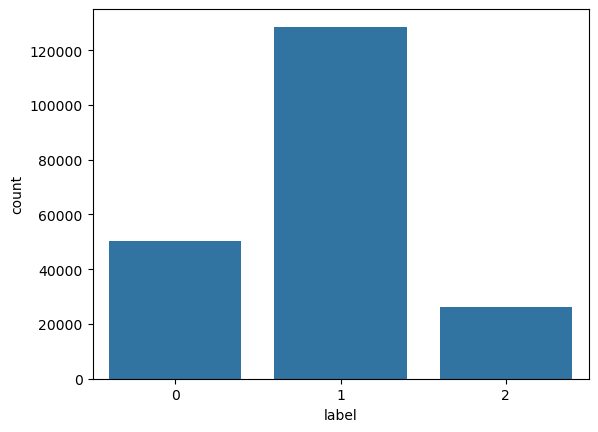

In [4]:
sns.countplot(x='label', data=df)

#### 3.1.2 Distribution of Document Lengths

EDA shows that query lengths are relatively short, averaging around 9.6 words, while titles are longer with a mean of 25.4 words. Both distributions have long tails, with maximum lengths of 246 for queries and 165 for titles, indicating some extreme outliers. The majority of queries fall between 6 and 11 words, and most titles between 15 and 31 words.

For preprocessing, consider capping overly long inputs and truncating or padding as needed for model input consistency. 

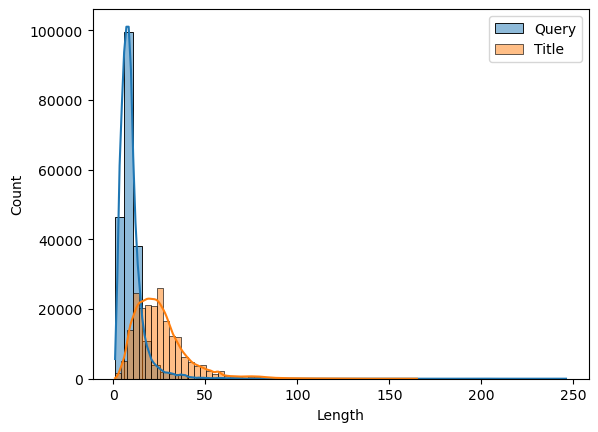

Query length description: count    205000.000000
mean          9.599380
std           7.293327
min           1.000000
25%           6.000000
50%           8.000000
75%          11.000000
max         246.000000
Name: query_len, dtype: float64
Title length description: count    205000.000000
mean         25.418395
std          14.729485
min           1.000000
25%          15.000000
50%          23.000000
75%          31.000000
max         165.000000
Name: title_len, dtype: float64


In [5]:
df['query_len'] = df['query'].apply(len)
df['title_len'] = df['title'].apply(len)

sns.histplot(df['query_len'], bins=50, kde=True, legend=True, label="Query")
sns.histplot(df['title_len'], bins=50, kde=True, legend=True, label="Title")
plt.legend()
plt.xlabel("Length")
plt.show()

print(f"Query length description: {df['query_len'].describe()}")
print(f"Title length description: {df['title_len'].describe()}")


#### 3.1.3 Overlap between query and title

To measure the textual similarity between queries and titles, we calculated the Jaccard similarity at the word level using Chinese word segmentation (jieba). The overall distribution of Jaccard similarity shows a relatively wide spread, indicating varying degrees of lexical overlap across samples.

When visualizing the similarity distributions by relevance labels, we observed no strong or consistent patterns. While higher relevance scores (label 2) tend to have slightly higher average similarity, the distributions of all three labels (0, 1, 2) overlap significantly. This suggests that simple word-level overlap is not a reliable standalone indicator of semantic relevance. In other words, queries and titles can be relevant even with low lexical overlap, possibly due to paraphrasing, synonym usage, or implicit relationships that word-level comparison fails to capture.ç.

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/mg/t_zxv0bx41x3ty06pvsqh1280000gn/T/jieba.cache
Loading model cost 0.370 seconds.
Prefix dict has been built successfully.


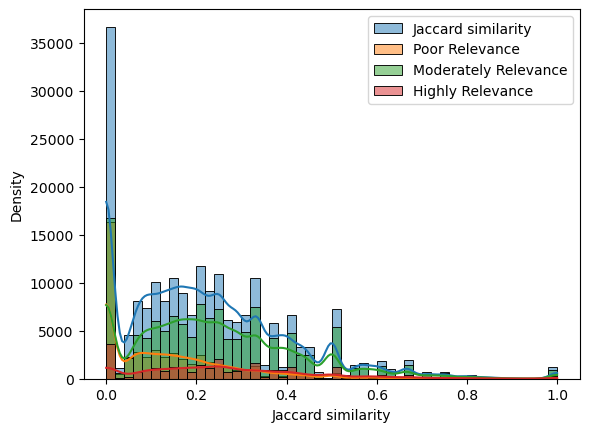

In [6]:
def calc_Jaccard(row):
    query_words = set(jieba.lcut(row['query']))
    title_words = set(jieba.lcut(row['title']))
    return len(query_words & title_words) / len(query_words | title_words)
df["Jaccard_similarity"] = df.apply(calc_Jaccard, axis=1)

sns.histplot(df['Jaccard_similarity'], bins=50, kde=True, legend=True, label='Jaccard similarity')
sns.histplot(
    df[df['label'] == 0]['Jaccard_similarity'],
    bins=50,
    kde=True,
    legend=True,
    label='Poor Relevance'
)
sns.histplot(
    df[df['label'] == 1]['Jaccard_similarity'],
    bins=50,
    kde=True,
    legend=True,
    label='Moderately Relevance'
)
sns.histplot(
    df[df['label'] == 2]['Jaccard_similarity'],
    bins=50,
    kde=True,
    legend=True,
    label='Highly Relevance'
)
plt.xlabel('Jaccard similarity')
plt.ylabel('Density')
plt.legend()
plt.show()

### 3.2  <a name='3.2'></a> Summary of EDA and Futher steps
#### Summary:
- The dataset is **label-imbalanced**.
- **Queries are short** (~9.6 words), while **titles are longer** (~25.4 words), with a few extreme outliers.
- **Jaccard similarity** shows weak correlation with relevance, indicating that **lexical overlap is not enough** to capture semantic relevance.

#### Next Steps:
- Address **label imbalance** using resampling or class-weighted loss.
- Apply **padding/truncation** to standardize input lengths.

##  4. <a name='4'></a>Data Module
[Back to Table of Contents](#top)

##  4.1 <a name='4.1'></a>Pre-processing

###  4.1.1 <a name='4.1.1'></a> Flitering out the Outliers

According to our EDA results, we identified extreme outliers in both query and title lengths. Extremely long texts may not only increase computational cost but also lead to noise in training, as they may not represent typical search engine queries or titles.

To mitigate this, we filtered out entries where:
- The **query length** exceeds 30 characters.
- The **title length** exceeds 50 characters.

In [9]:
def filterout_length(data, max_len, column='text'):
    filtered_data = []
    for d in data:
        if len(d[column]) <= max_len:
            filtered_data.append(d)
    return filtered_data

for name, data in data_dict.items():
    data_dict[name] = filterout_length(data, 50, 'title')
    data_dict[name] = filterout_length(data_dict[name], 30, 'query')


###  4.1.2 <a name='4.1.2'></a> Upsampling of the training data via LLMs
To balance the dataset, we use follow steps:

1. Drop 50% of the data with *Lable1*;
2. Use the LLM to rephrase all the data with *Label2* and add this sample to dataset.

This both balances the class distribution and increases dataset diversity through LLM-generated paraphrases.

In [8]:
def chat_with_ollama(sentence):
    client = ollama.Client()

    model_name = "mistral"

    response = client.chat(model=model_name, messages=[
        {"role": "user", "content": f"""Please rephrase this sentence:{sentence}"""}
    ],
    options={
        "num_predict": 15  # This is the equivalent of max_tokens in Ollama
    })

    return response['message']['content']

newdata_dict = {}
for name, data in data_dict.items():
    newdata_dict[name] = []
    id = 0
    for item in tqdm(data):
        id += 1
        item['id'] = id
        if item['label'] == '1':
            if random.random() < 0.5:
                newdata_dict[name].append(item)
        elif item['label'] == '2':
            newdata_dict[name].append(item)
            id += 1
            newdata_dict[name].append({
                "id": id,
                "query": chat_with_ollama(item['query']),
                "label": "2",
                "title": item['title'],
            })
        else:
            newdata_dict[name].append(item)

# save new data
for name, data in newdata_dict.items():
    with open(os.path.join(dataset_path, f"{name}_new.json"), "w") as f:
        json.dump(data, f, indent=4)
                

  0%|          | 0/167097 [00:00<?, ?it/s]

  0%|          | 0/18597 [00:00<?, ?it/s]

  0%|          | 0/4654 [00:00<?, ?it/s]

## 4.2 <a name='4.2'></a> Overview of the New Dataset

After comprehensive preprocessing, we finalized a clean and balanced dataset containing 154,592 samples. Each entry includes a query, a corresponding document title, and a relevance label (0–2). The dataset has been filtered to remove outlier lengths, with queries capped at 30 characters (mean ≈ 10.1) and titles at 50 (mean ≈ 22.8). Label imbalance was addressed via downsampling and LLM-based augmentation, resulting in a semantically diverse and model-ready corpus for training relevance models.


#texts: 154592
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154592 entries, 0 to 154591
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      154592 non-null  int64 
 1   query   154592 non-null  object
 2   title   154592 non-null  object
 3   label   154592 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 4.7+ MB
None


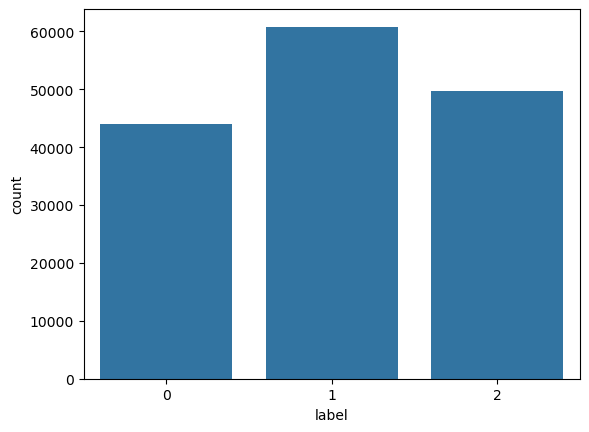

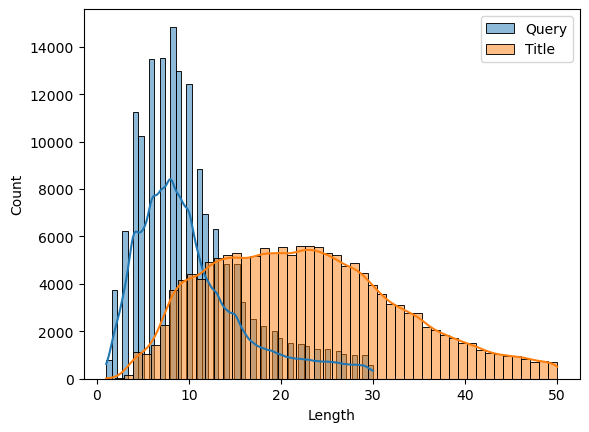

Query length description: count    154592.000000
mean         10.086563
std           5.892387
min           1.000000
25%           6.000000
50%           9.000000
75%          13.000000
max          30.000000
Name: query_len, dtype: float64
Title length description: count    154592.000000
mean         22.766631
std          10.286630
min           1.000000
25%          15.000000
50%          22.000000
75%          29.000000
max          50.000000
Name: title_len, dtype: float64


In [14]:
files = ['train_new.json', 'dev_new.json', 'test_new.json']
data_dict = {}

for file in files:
    file_path = os.path.join(dataset_path, file)
    with open(file_path, 'r', encoding='utf-8') as f:
        data_dict[file] = json.load(f)

records = []
for name, data in data_dict.items():
    records.extend(data)
df = pd.DataFrame.from_records(records)
df["label"] = df["label"].astype(int)

print(f'#texts: {len(df)}')
print(df.info())
df.head()

sns.countplot(x='label', data=df)
plt.show()

df['query_len'] = df['query'].apply(len)
df['title_len'] = df['title'].apply(len)

sns.histplot(df['query_len'], bins=50, kde=True, legend=True, label="Query")
sns.histplot(df['title_len'], bins=50, kde=True, legend=True, label="Title")
plt.legend()
plt.xlabel("Length")
plt.show()

print(f"Query length description: {df['query_len'].describe()}")
print(f"Title length description: {df['title_len'].describe()}")

##  5. <a name='5'></a>Model Module
[Back to Table of Contents](#top)

##  6. <a name='6'></a>Results
[Back to Table of Contents](#top)

We report the performance of various models on the document relevance classification task across three relevance levels: Poor, Moderately, and Highly relevant. The evaluation metrics include Precision, Recall, and F1-score for each relevance category, along with the macro-averaged results.


<table border="1" cellspacing="0" cellpadding="5">
  <thead>
    <tr>
      <th rowspan="2">Model</th>
      <th colspan="3">Poor relevance</th>
      <th colspan="3">Moderately relevant</th>
      <th colspan="3">Highly relevant</th>
      <th colspan="3">Macro Average</th>
    </tr>
    <tr>
      <th>Precision</th><th>Recall</th><th>F1-score</th>
      <th>Precision</th><th>Recall</th><th>F1-score</th>
      <th>Precision</th><th>Recall</th><th>F1-score</th>
      <th>Precision</th><th>Recall</th><th>F1-score</th>
    </tr>
  </thead>
  <tbody>
    <tr><td>MLP</td><td>0.6166</td><td>0.1290</td><td>0.2134</td><td>0.6484</td><td>0.9725</td><td>0.7780</td><td>0.2222</td><td>0.0032</td><td>0.0062</td><td>0.4957</td><td>0.3682</td><td>0.3326</td></tr>
    <tr><td>CNN</td><td>0.8333</td><td>0.0041</td><td>0.0082</td><td>0.6322</td><td>0.9984</td><td>0.7742</td><td>0.2000</td><td>0.0016</td><td>0.0031</td><td>0.5552</td><td>0.3347</td><td>0.2618</td></tr>
    <tr><td>Transformer</td><td>0.5637</td><td>0.3366</td><td>0.4215</td><td>0.6912</td><td>0.8665</td><td>0.7689</td><td>0.4717</td><td>0.2373</td><td>0.3158</td><td>0.5755</td><td>0.4801</td><td>0.5021</td></tr>
    <tr><td>BGE+Transformer</td><td>0.7020</td><td>0.4326</td><td>0.5353</td><td>0.7245</td><td>0.8724</td><td>0.7916</td><td>0.4900</td><td>0.3497</td><td>0.4081</td><td>0.6388</td><td>0.5516</td><td>0.5784</td></tr>
    <tr><td>BERT(Single)</td><td>0.7227</td><td>0.5906</td><td>0.6500</td><td>0.7780</td><td>0.8531</td><td>0.8138</td><td>0.5383</td><td>0.4668</td><td>0.5000</td><td>0.6797</td><td>0.6368</td><td>0.6546</td></tr>
    <tr><td>BERT(Double)</td><td>0.6518</td><td>0.4582</td><td>0.5381</td><td>0.7389</td><td>0.8446</td><td>0.7882</td><td>0.4842</td><td>0.4130</td><td>0.4458</td><td>0.6249</td><td>0.5719</td><td>0.5907</td></tr>
    <tr><td>RNN(Single)</td><td>0.5082</td><td>0.4119</td><td>0.4550</td><td>0.6938</td><td>0.8297</td><td>0.7557</td><td>0.4174</td><td>0.1598</td><td>0.2311</td><td>0.5398</td><td>0.4671</td><td>0.4806</td></tr>
    <tr><td>RNN(Double)</td><td>0.5679</td><td>0.3598</td><td>0.4405</td><td>0.6939</td><td>0.8563</td><td>0.7666</td><td>0.4196</td><td>0.2231</td><td>0.2931</td><td>0.5605</td><td>0.4797</td><td>0.4995</td></tr>
    <tr><td>LSTM(Single)</td><td>0.5357</td><td>0.4467</td><td>0.4871</td><td>0.7185</td><td>0.8177</td><td>0.7649</td><td>0.4887</td><td>0.3070</td><td>0.3771</td><td>0.5810</td><td>0.5238</td><td>0.5430</td></tr>
    <tr><td>LSTM(Double)</td><td>0.5707</td><td>0.3937</td><td>0.4770</td><td>0.7075</td><td>0.8433</td><td>0.7684</td><td>0.4680</td><td>0.2896</td><td>0.3578</td><td>0.5815</td><td>0.5089</td><td>0.5307</td></tr>
    <tr><td>GRU(Single)</td><td>0.5445</td><td>0.4351</td><td>0.4837</td><td>0.7197</td><td>0.8192</td><td>0.7662</td><td>0.4703</td><td>0.3259</td><td>0.3850</td><td>0.5782</td><td>0.5268</td><td>0.5450</td></tr>
    <tr><td>GRU(Double)</td><td>0.5727</td><td>0.4202</td><td>0.4847</td><td>0.7158</td><td>0.8370</td><td>0.7716</td><td>0.4821</td><td>0.3196</td><td>0.3844</td><td>0.5902</td><td>0.5256</td><td>0.5459</td></tr>
  </tbody>
</table>


Among all models, **BERT (Single)** achieved the highest overall macro-averaged F1-score (0.6546), indicating its superior capability in handling document relevance classification tasks. This strong performance can be attributed to BERT's pre-trained contextual embeddings, which enable it to capture complex semantic relationships within the text, particularly benefiting "Moderately relevant" and "Highly relevant" categories.

On the other hand, **MLP** and **CNN** performed relatively poorly, especially on "Highly relevant" instances, where their F1-scores are extremely low (0.0062 and 0.0031, respectively). This could be because simple MLP and CNN architectures lack the sequential modeling ability required to understand long document structures and fine-grained semantic differences. Specifically, CNNs tend to focus on local patterns but may struggle to capture the broader contextual information necessary for relevance prediction in lengthy documents.

**Transformer** and **BGE+Transformer** models achieved better results than simple RNN or CNN models, showing the advantage of self-attention mechanisms in capturing global dependencies. Notably, integrating BGE with Transformer slightly improved the overall performance, suggesting that additional guidance from a pre-trained backbone enhances the model's robustness.

Recurrent models (RNN, LSTM, GRU) with double-layer architectures slightly outperformed their single-layer counterparts, reflecting the importance of deeper modeling for complex sequence understanding. However, compared to Transformer-based models, their gains were still limited, possibly due to vanishing gradient issues or less effective long-range dependency modeling.


##  7. <a name='7'></a>Conclusion & Future Development
[Back to Table of Contents](#top)

In this project, we systematically explored the effectiveness of various deep learning architectures for query-document relevance prediction on the QBQTC dataset. Our experiments covered a range of models, including traditional RNN-based methods (RNN, LSTM, GRU), Transformer architectures, and BERT variants.

From the evaluation results, several key conclusions can be drawn:

BERT-based models demonstrated the best overall performance, with the BERT (Single) model achieving the highest Macro Average F1-score (0.6546). This highlights the advantage of using pretrained contextual embeddings and deep bidirectional representations in relevance prediction tasks.
Transformer and BGE+Transformer models also performed competitively, outperforming traditional RNN-based models. The self-attention mechanism effectively captures long-range dependencies, which is crucial in matching queries and document titles.
RNN, LSTM, and GRU models showed moderate performance. Although GRU and LSTM models achieved relatively higher F1-scores among the RNN variants, they still lagged behind Transformer-based methods. This could be attributed to their limited ability to model complex interactions over long sequences compared to attention-based architectures.
Simple models like MLP and CNN performed poorly, with the CNN model achieving the lowest Macro Average F1-score (0.2618). The limited expressiveness and inability to capture intricate semantic relationships between queries and documents likely contributed to their subpar performance.
Several possible factors influenced these outcomes:

Pretrained language models like BERT bring strong generalization capabilities from large corpora, providing a significant head start over models trained from scratch.
Attention mechanisms, as used in Transformers, allow models to selectively focus on important parts of the input, which is especially important for short but semantically rich query-document pairs.
Traditional RNNs, despite their sequential modeling strength, struggle with long-term dependencies and are less effective at highlighting the most relevant information for retrieval tasks.
In summary, Transformer-based and pretrained models clearly offer substantial advantages for query-document relevance prediction in web search scenarios. Future work could explore larger model variants, domain-specific pretraining, or incorporating additional signals like authority and timeliness to further enhance retrieval performance.

### Reference:  
[1] Devlin, J., Chang, M. W., Lee, K., & Toutanova, K. (2018). Bert: Pre-training of deep bidirectional transformers for language understanding. arXiv preprint arXiv:1810.04805.  
[2] Tay, Y., Dehghani, M., Bahri, D., & Metzler, D. (2020). Efficient transformers: A survey. ACM Computing Surveys (CSUR).